# Shortest-Path

#### Fix path and import caldera

In [1]:
from os.path import join, isfile
import os
import sys

def find_pkg(name: str, depth: int):
    if depth <= 0:
        ret = None
    else:
        d = ['..'] * depth
        path_parts = d + [name, '__init__.py']
        
        if isfile(join(*path_parts)):
            ret = d
        else:
            ret = find_pkg(name, depth-1)
    return ret

def find_and_ins_syspath(name: str, depth: int):
    path_parts = find_pkg(name, depth)
    if path_parts is None:
        raise RuntimeError("Could not find {}. Try increasing depth.".format(name))
    path = join(*path_parts)
    if path not in sys.path:
        sys.path.insert(0, path)

try:
    import caldera
except ImportError:
    find_and_ins_syspath('caldera', 3)

import caldera

## Data Generation

To generate examples, we are going to use caldera's networkx graph generator utilties and the `caldera.transforms.networkx` module to perform graph preprocessing.

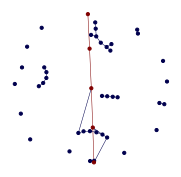

In [2]:
import networkx as nx
import numpy as np
import pprint
import matplotlib.pyplot as plt
from caldera.testing import annotate_shortest_path
from caldera.transforms import Compose
from caldera.transforms.networkx import NetworkxAttachNumpyOneHot
from caldera.transforms.networkx import NetworkxNodesToStr
from caldera.transforms.networkx import NetworkxSetDefaultFeature
from caldera.transforms.networkx import NetworkxToDirected
from caldera.utils._tools import _resolve_range
from caldera.utils.nx.generators import _uuid_chain
from caldera.utils.nx.generators import chain_graph
from caldera.utils.nx.generators import compose_and_connect
from caldera.utils.nx.generators import random_graph
%matplotlib inline

def generate_shorest_path_example(n_nodes, density, path_length, compose_density = None):
    d = _resolve_range(density)
    l = _resolve_range(path_length)
    if compose_density is None:
        cd = d
    else:
        cd = _resolve_range(compose_density)
    path = list(_uuid_chain(l))
    h = chain_graph(path, nx.Graph)
    g = random_graph(n_nodes, density=d)
    graph = compose_and_connect(g, h, cd)

    annotate_shortest_path(
        graph,
        True,
        True,
        source_key="source",
        target_key="target",
        path_key="shortest_path",
        source=path[0],
        target=path[-1],
    )

    preprocess = Compose(
        [
            NetworkxSetDefaultFeature(
                node_default={"source": False, "target": False, "shortest_path": False},
                edge_default={"shortest_path": False},
            ),
            NetworkxAttachNumpyOneHot(
                "node", "source", "_features", classes=[False, True]
            ),
            NetworkxAttachNumpyOneHot(
                "node", "target", "_features", classes=[False, True]
            ),
            NetworkxAttachNumpyOneHot(
                "edge", "shortest_path", "_target", classes=[False, True]
            ),
            NetworkxAttachNumpyOneHot(
                "node", "shortest_path", "_target", classes=[False, True]
            ),
            NetworkxSetDefaultFeature(
                node_default={"_features": np.array([0.0]), "_target": np.array([0.0])},
                edge_default={"_features": np.array([0.0]), "_target": np.array([0.0])},
                global_default={
                    "_features": np.array([0.0]),
                    "_target": np.array([0.0]),
                },
            ),
            NetworkxNodesToStr(),
            NetworkxToDirected(),
        ]
    )

    return preprocess([graph])[0]


def draw_shortest_path(g, ax=None, node_size=10, edge_width=0.5, cmap=None, pos=None):
    if ax is None:
        fig = plt.figure(figsize=(3, 3))
        ax = fig.gca()
    ax.axis('off')
    
    g = nx.to_undirected(g)
    nodelist = list(g.nodes)

    node_color = []
    for n in nodelist:
        node_color.append(g.nodes[n]['shortest_path'])

    edge_list = []
    edge_color = []
    for n1, n2, edata in g.edges(data=True):
        edge_list.append((n1, n2))
        edge_color.append(edata['shortest_path'])

    if cmap is None:
        cmap = plt.get_cmap('seismic')
    if pos is None:
        pos = nx.layout.spring_layout(g)
    elif callable(pos):
        pos = pos(g)
    nx.draw_networkx_nodes(g, pos=pos, node_color=node_color, node_size=node_size, ax=ax, cmap=cmap)
    nx.draw_networkx_edges(g, pos=pos, width=edge_width, edge_color=edge_color, ax=ax, edge_cmap=cmap)
    return ax
    

def custom_layout(g):
    s1 = []
    s2 = []
    for n, ndata in g.nodes(data='shortest_path'):
        if ndata:
            s1.append(n)
        else:
            s2.append(n)

    sg1 = g.subgraph(s1)
    sg2 = g.subgraph(s2)

    p1 = nx.layout.spring_layout(sg1)
    p2 = nx.layout.spring_layout(sg2)

    pos = {}
    for p_ in [p1, p2]:
        for n in p_:
            pos[n] = p_[n]
    return pos
        

g = generate_shorest_path_example((10, 100), (0.03, 0.03), (5, 10), (0.01, 0.02))
draw_shortest_path(g, pos=custom_layout)

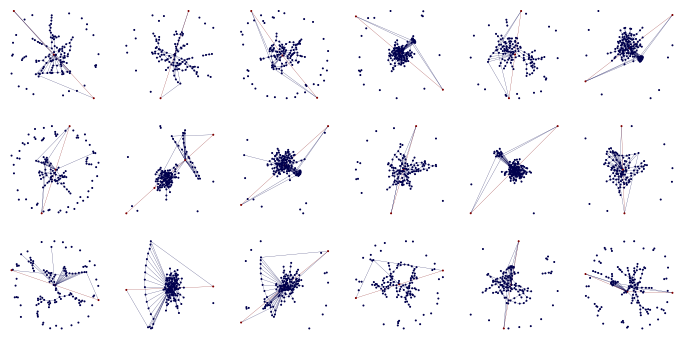

In [3]:
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for row in axes:
    for ax in row:
        g = generate_shorest_path_example((100, 150), (0.01, 0.03), (5, 30), (0.005, 0.02))
        draw_shortest_path(g, ax, node_size=1, edge_width=0.2, pos=custom_layout)

We can convert `networkx.Graph` into GraphData

In [4]:
from caldera.data import GraphData

input_graph = GraphData.from_networkx(g, feature_key='_features')
target_graph = GraphData.from_networkx(g, feature_key='_target')

print(input_graph)
print(target_graph)

<GraphData size(n,e,g)=torch.Size([153, 310, 1]) features(n,e,g)=torch.Size([4, 1, 1])>
<GraphData size(n,e,g)=torch.Size([153, 310, 1]) features(n,e,g)=torch.Size([2, 2, 1])>


### Creating Dataset

Generate `networkx.Graphs`, annotate the shortest path, convert features to `np.ndarray`.

In [5]:
from caldera.dataset import GraphDataset
from caldera.data import GraphData, GraphBatch
from caldera.data import GraphDataLoader
from tqdm import tqdm

NUM_GRAPHS = 5000
NUM_NODES = (10, 100)
DENSITY = (0.01, 0.03)
PATH_LEN  = (5, 10)
COMPOSITION_DENSITY  = (0.01, 0.02)

nx_graphs = []
for _ in tqdm(range(NUM_GRAPHS)):
    nxg = generate_shorest_path_example(NUM_NODES, DENSITY, PATH_LEN, COMPOSITION_DENSITY)
    nx_graphs.append(nxg)

100%|██████████| 5000/5000 [00:19<00:00, 252.18it/s]


Check generated graphs.

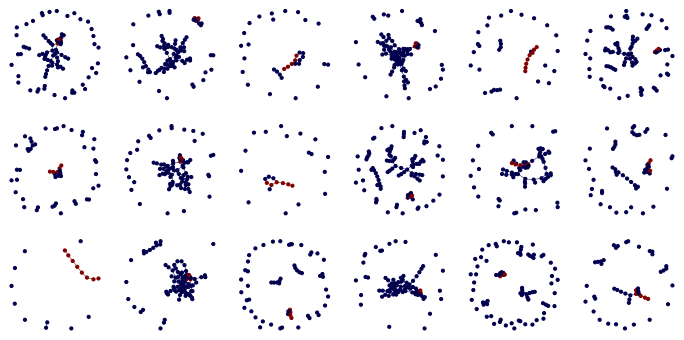

In [6]:
from caldera.utils.functional import chain_each

fig, axes = plt.subplots(3, 6, figsize=(12, 6))
axes = chain_each()(axes)
for ax, g in zip(axes, nx_graphs):
    draw_shortest_path(g, ax)

100%|██████████| 100/100 [00:01<00:00, 99.34it/s]


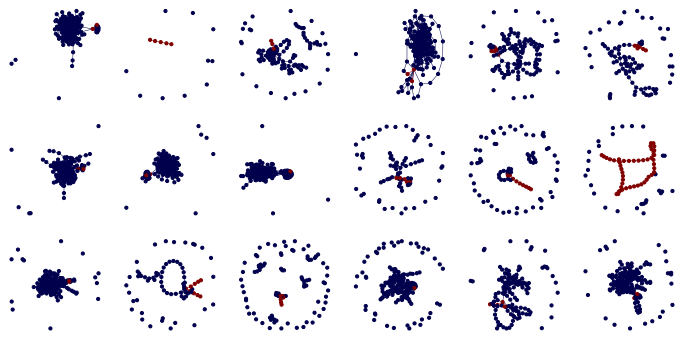

In [7]:
EVAL_NUM_GRAPHS = 100
EVAL_NUM_NODES = (10, 200)
EVAL_DENSITY = (0.01, 0.03)
EVAL_PATH_LEN  = (5, 50)
EVAL_COMPOSITION_DENSITY  = (0.001, 0.01)

eval_graphs = []
for _ in tqdm(range(EVAL_NUM_GRAPHS)):
    nxg = generate_shorest_path_example(EVAL_NUM_NODES, EVAL_DENSITY, EVAL_PATH_LEN, EVAL_COMPOSITION_DENSITY)
    eval_graphs.append(nxg)

fig, axes = plt.subplots(3, 6, figsize=(12, 6))
axes = chain_each()(axes)
for ax, g in zip(axes, eval_graphs):
    draw_shortest_path(g, ax)

Create a paired data loader from input and target datalists.

In [8]:
input_datalist = [GraphData.from_networkx(g, feature_key='_features') for g in nx_graphs]
target_datalist = [GraphData.from_networkx(g, feature_key='_target') for g in nx_graphs]

loader = GraphDataLoader(input_datalist, target_datalist, batch_size=32)

for _input, _target in loader:
    print(_input)
    print(_target)
    break

<GraphBatch size(n,e,g)=torch.Size([2068, 3010, 32]) features(n,e,g)=torch.Size([4, 1, 1])>
<GraphBatch size(n,e,g)=torch.Size([2068, 3010, 32]) features(n,e,g)=torch.Size([2, 2, 1])>


Plot tensor object fingerprints.

/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/seaborn/matrix.py:336: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  ax.figure.draw(ax.figure.canvas.get_renderer())


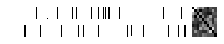

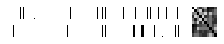

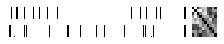

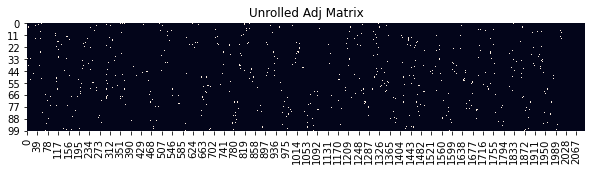

In [9]:
from caldera.data.utils import graph_matrix
from caldera.utils import functional
import seaborn as sns

def adj_fingerprint(data, step_size=50):
    t = graph_matrix(data, include_edge_attr=False, fill_value=0, edge_value=1)
    n = t.numpy().squeeze()
    
    _n = np.zeros_like(n[:step_size, :step_size])
    for i in np.arange(0, n.shape[0], step=step_size):
        n2 = n[i:i+step_size, i:i+step_size]
        pad = step_size - n2.shape[0]
        if pad > 0:
            n2 = np.hstack([n2, np.zeros((n2.shape[0], pad))])
            n2 = np.vstack([n2, np.zeros((pad, n2.shape[1]))])
        _n += n2
    return _n

def plot_fingerprint(data):
    fig = plt.figure(constrained_layout=True, figsize=(3, 0.5))
    gs = fig.add_gridspec(2, 5)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[:, -1:])
    
    sns.heatmap(data.x[:, :1].T, ax=ax1, cbar=False, xticklabels=False, yticklabels=False, cmap="gray")
    sns.heatmap(data.e[:, :1].T, ax=ax2, cbar=False, xticklabels=False, yticklabels=False, cmap="gray")
    
    sns.heatmap(adj_fingerprint(data, step_size=10), cbar=False, xticklabels=False, yticklabels=False, cmap="gray")
    return fig

def split(n, step_size):
    for i in np.arange(0, n.shape[0], step=step_size):
        n2 = n[i:i+step_size, i:i+step_size]
        pad = step_size - n2.shape[0]
        if pad > 0:
            n2 = np.hstack([n2, np.zeros((n2.shape[0], pad))])
            n2 = np.vstack([n2, np.zeros((pad, n2.shape[1]))])
        yield n2

for _input, _target in functional.iter_count(3)(loader):
    fig = plot_fingerprint(_target)
n = graph_matrix(_target).numpy().sum(axis=2)
x = np.hstack(list(split(n, 100)))
fig = plt.figure(figsize=(10, 2))
ax = fig.gca()
ax.set_title("Unrolled Adj Matrix")
sns.heatmap(x, ax=ax, cbar=False)

Notice that the input and target data are batched together according to the batch size. Node attributes can be accessed via `x`, edge attributes `e` and global attributes `g`. Now data is ready to be loaded into a `caldera` network.

## Graph Network

We are going to build a graph network to handle the data we just created.

We are going to use a flexible `encoder -> core[x] -> decoder` architecture for this problem. The architecture consists of 4 main networks, the **encoder**, **core**, **decoder**, and **output_transform** networks. The **encoder** encodes graph data inputs into arbitrary shapes. The **core** is the central graph message processing network. The **decoder** decodes encoded data. Finally, the **output_transform** transformed decoded data for final output. 

Setting up the network looks like the following:

``` python
class Network(torch.nn.Module):

    def __init__(...):
        super().__init__()
    
        self.config = {...}

        self.encoder = ...
        self.core = ...
        self.decoder = ...
        self.out_transform = ...  

    def forward(self, data, steps, save_all: bool = False):
        """The encoder -> core -> decode loop"""
        encoded = self.encoder(data) # encode data
        
        outputs = []
        for _ in range(steps):
            latent = self.core(encoded)
            encoded = self.decoder(latent)
            outputs.append(self.out_transform(latent)
        return outputs
```

### Flex Modules and Flex Dimensions

Setting up this network with the correct dimensions can become tricky, so we introduce a new module, the `Flex` module, which can resolve unknown dimensions on runtime. To make a module a `Flex` module, we just call `Flex` with any `torch.nn.Module`, as in `Flex(torch.nn.Linear)` or `Flex(MyAwesomeModule)`. To initialize the module with unknown dimensions, you use the flexible dimension object `Flex.d` in places where the dimension is to be resolve on runtime, as in `Flex(torch.nn.Linear)(Flex.d(), 10)`.

In [10]:
from caldera.blocks import Flex
import torch

FlexLinear = Flex(torch.nn.Linear)

linear0 = torch.nn.Linear(3, 10)
flex_linear0 = FlexLinear(Flex.d(), 10)
print(linear0)
print(flex_linear0)

Linear(in_features=3, out_features=10, bias=True)
FlexBlock(
	(unresolved_module): Linear(FlexDim(0, 1), 10, 
)


Notice that the FlexBlock indicates it is current unresolved. To resovle it, we need to provide it with a data example. You'll see the module is now resolved.

In [11]:
example = torch.zeros((1, 10))

flex_linear0(example)

print(flex_linear0)

FlexBlock(
  (resolved_module): Linear(in_features=10, out_features=10, bias=True)
)


### Aggregators

Aggregators are layers that indicate how data is processed and aggregated between neighbors.

### Final Network

In [12]:
from caldera.blocks import NodeBlock, EdgeBlock, GlobalBlock
from caldera.blocks import AggregatingNodeBlock, AggregatingEdgeBlock, AggregatingGlobalBlock
from caldera.blocks import MultiAggregator
from caldera.blocks import Flex
from caldera.models import GraphCore, GraphEncoder
from caldera.defaults import CalderaDefaults as defaults

In [13]:
import torch
from caldera.defaults import CalderaDefaults as defaults
from caldera.blocks import Flex, NodeBlock, EdgeBlock, GlobalBlock, MLP, AggregatingEdgeBlock, AggregatingNodeBlock, \
    MultiAggregator, AggregatingGlobalBlock
from caldera.models import GraphEncoder, GraphCore
from caldera.data import GraphBatch


class Network(torch.nn.Module):
    def __init__(
            self,
            latent_sizes=(32, 32, 32),
            out_sizes=(1, 1, 1),
            latent_depths=(1, 1, 1),
            dropout: float = None,
            pass_global_to_edge: bool = True,
            pass_global_to_node: bool = True,
            activation=defaults.activation,
            out_activation=defaults.activation,
            edge_to_node_aggregators=tuple(["add", "max", "mean", "min"]),
            edge_to_global_aggregators=tuple(["add", "max", "mean", "min"]),
            node_to_global_aggregators=tuple(["add", "max", "mean", "min"]),
            aggregator_activation=defaults.activation,
    ):
        super().__init__()
        self.config = {
            "sizes": {
                'latent': {
                    "edge": latent_sizes[0],
                    "node": latent_sizes[1],
                    "global": latent_sizes[2],
                    "edge_depth": latent_depths[0],
                    "node_depth": latent_depths[1],
                    "global_depth": latent_depths[2],
                },
                'out': {
                    'edge': out_sizes[0],
                    'node': out_sizes[1],
                    'global': out_sizes[2],
                    'activation': out_activation,
                }
            },
            'activation': activation,
            "dropout": dropout,
            "node_block_aggregator": edge_to_node_aggregators,
            "global_block_to_node_aggregator": node_to_global_aggregators,
            "global_block_to_edge_aggregator": edge_to_global_aggregators,
            "aggregator_activation": aggregator_activation,
            "pass_global_to_edge": pass_global_to_edge,
            "pass_global_to_node": pass_global_to_node,
        }

        ###########################
        # encoder
        ###########################

        self.encoder = self._init_encoder()
        self.core = self._init_core()
        self.decoder = self._init_encoder()
        self.output_transform = self._init_out_transform()

    def _init_encoder(self):
        return GraphEncoder(
            EdgeBlock(Flex(MLP)(Flex.d(), self.config['sizes']['latent']['edge'], dropout=self.config['dropout'])),
            NodeBlock(Flex(MLP)(Flex.d(), self.config['sizes']['latent']['node'], dropout=self.config['dropout'])),
            GlobalBlock(Flex(MLP)(Flex.d(), self.config['sizes']['latent']['global'], dropout=self.config['dropout'])),
        )

    def _init_core(self):
        edge_layers = [self.config['sizes']['latent']['edge']] * self.config['sizes']['latent']['edge_depth']
        node_layers = [self.config['sizes']['latent']['node']] * self.config['sizes']['latent']['node_depth']
        global_layers = [self.config['sizes']['latent']['global']] * self.config['sizes']['latent']['global_depth']

        return GraphCore(
            AggregatingEdgeBlock(
                torch.nn.Sequential(
                    Flex(MLP)(Flex.d(), *edge_layers, dropout=self.config['dropout'], layer_norm=True),
                )
            ),
            AggregatingNodeBlock(
                torch.nn.Sequential(
                    Flex(MLP)(Flex.d(), *node_layers, dropout=self.config['dropout'], layer_norm=True),
                ),
                Flex(MultiAggregator)(
                    Flex.d(),
                    self.config["node_block_aggregator"],
                    activation=self.config["aggregator_activation"],
                ),
            ),
            AggregatingGlobalBlock(
                torch.nn.Sequential(
                    Flex(MLP)(
                        Flex.d(), *global_layers, dropout=self.config['dropout'], layer_norm=True
                    ),
                ),
                edge_aggregator=Flex(MultiAggregator)(
                    Flex.d(),
                    self.config["global_block_to_edge_aggregator"],
                    activation=self.config["aggregator_activation"],
                ),
                node_aggregator=Flex(MultiAggregator)(
                    Flex.d(),
                    self.config["global_block_to_node_aggregator"],
                    activation=self.config["aggregator_activation"],
                ),
            ),
            pass_global_to_edge=self.config["pass_global_to_edge"],
            pass_global_to_node=self.config["pass_global_to_node"],
        )

    def _init_out_transform(self):
        return GraphEncoder(
            EdgeBlock(
                torch.nn.Sequential(
                    Flex(torch.nn.Linear)(Flex.d(), self.config['sizes']['out']['edge']),
                    self.config['sizes']['out']['activation']()
                )
            ),
            NodeBlock(
                torch.nn.Sequential(
                    Flex(torch.nn.Linear)(Flex.d(), self.config['sizes']['out']['node']),
                    self.config['sizes']['out']['activation']()
                )
            ),
            GlobalBlock(
                torch.nn.Sequential(
                    Flex(torch.nn.Linear)(Flex.d(), self.config['sizes']['out']['global']),
                    self.config['sizes']['out']['activation']()
                )
            )
        )

    def _forward_encode(self, data):
        e, x, g = self.encoder(data)
        return GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)

    def _forward_decode(self, data):
        e, x, g = self.decoder(data)
        return GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)

    def _forward_core(self, latent0, data):
        e = torch.cat([latent0.e, data.e], dim=1)
        x = torch.cat([latent0.x, data.x], dim=1)
        g = torch.cat([latent0.g, data.g], dim=1)
        data = GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)
        e, x, g = self.core(data)
        return GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)

    def _forward_out(self, data):
        e, x, g = self.output_transform(data)
        return GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)

    def forward(self, data, steps, save_all: bool = False):
        data = self._forward_encode(data)
        latent0 = data

        outputs = []
        for _ in range(steps):
            data = self._forward_core(latent0, data)
            data = self._forward_decode(data)
            out_data = self._forward_out(data)
            if save_all:
                outputs.append(out_data)
            else:
                outputs = [out_data]
        return outputs
    
    

Provide example to resolve Flex modules

In [14]:
network = Network()
network.forward(_input, 10)

[<GraphBatch size(n,e,g)=torch.Size([2016, 3066, 32]) features(n,e,g)=torch.Size([1, 1, 1])>]

## Training

### Create loaders

In [15]:
input_datalist = [GraphData.from_networkx(g, feature_key='_features') for g in nx_graphs]
target_datalist = [GraphData.from_networkx(g, feature_key='_target') for g in nx_graphs]
eval_input_datalist = [GraphData.from_networkx(g, feature_key='_features') for g in eval_graphs]
eval_target_datalist = [GraphData.from_networkx(g, feature_key='_target') for g in eval_graphs]
loader = GraphDataLoader(input_datalist, target_datalist, batch_size=512)
eval_loader = GraphDataLoader(eval_input_datalist, eval_target_datalist, batch_size=len(eval_input_datalist))

In [16]:
# import wandb
# wandb.init(
#     project='caldera-shortest-path',
#     tags=['narratives', 'docs'],
#     group='shortest_path'
# )
# from tqdm.auto import tqdm

# # get device
# if torch.cuda.is_available():
#     print("cuda available")
#     cuda_device = torch.cuda.current_device()
#     device = 'cuda:' + str(cuda_device)
# else:
#     device = 'cpu'

# # initialize network    
# network = Network()

# # resolve
# for input_batch, _ in loader:
#     x = input_batch.x
#     network(input_batch, 10)
#     break
    
# # send to device
# network.to(device, non_blocking=True)
# loss_fn = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.AdamW(network.parameters())

# # TODO: loss should use all output to accomplish goal in min steps
# # training loop
# num_epochs = 1000
# for epoch in tqdm(range(num_epochs)):
#     running_loss = torch.tensor(0., device=device)
#     for input_batch, target_batch in loader:
#         network.train()
#         input_batch = input_batch.to(device)
#         target_batch = target_batch.to(device)
        
#         output = network(input_batch, 10)[0]
#         x, y = output.x, target_batch.x
#         loss = loss_fn(x.flatten(), y[:, 0].flatten())
#         loss.backward()
        
#         with torch.no_grad():
#             running_loss += loss
        
#         optimizer.step()
#         optimizer.zero_grad()
        
#     wandb.log({'train_loss': running_loss.detach().cpu().item()}, step=epoch)
# #     if epoch % 10:
# #         network.eval()
# #         running_eval_loss = 0.
# #         for eval_input_batch, eval_target_batch in eval_loader:
# #             eval_input_batch = eval_input_batch.to(device)
# #             eval_target_batch = eval_target_batch.to(device)
                
# #             eval_out = network(eval_input_batch, 10)[0]
# #             x, y = eval_out.x, eval_target_batch.x
# #             eval_loss = loss_fn(x.flatten(), y[:, 0].flatten())
# #             running_eval_loss += eval_loss.detach().cpu().item()
# #         wandb.log({"eval_loss": running_eval_loss}, step=epoch)

In [17]:
# g = generate_shorest_path_example(100, 0.03, 30, compose_density=0.001)
# draw_shortest_path(g)

# data = GraphBatch.from_networkx_list([g], feature_key='_features')
# data.to(device)
# network(data, 10)

## Pytorch Lightning Training

In [18]:
import pytorch_lightning as pl
from torch.functional import F

class LitModel(pl.LightningModule):

    def __init__(self, network, preloader):
        super().__init__()
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.network = network
        self.preloader = preloader

    def forward(self, x, steps):
        return self.network(x, steps)
    
    def training_step(self, batch, batch_idx):
        input_data, target_data = batch
        x = input_data.x
        y = target_data.x[:, 0].flatten()
        out = self(input_data, 10)
        
        losses = []
        for _out in out:
            _loss = self.loss_fn(y_hat, _out)
            losses.append(_loss)
        y_hat = torch.sum(torch.cat(losses))
        
        loss = self.loss_fn(y_hat, y)
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, on_step=False, on_epoch=True, reduce_fx=torch.mean)
        return result
    
    def validation_step(self, batch, batch_idx):
        input_data, target_data = batch
        x = input_data.x
        y = target_data.x[:, 0].flatten()
        out = self(input_data, 10)
        y_hat = out[-1].x.flatten()
        
        loss = self.loss_fn(y_hat, y)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('eval_loss', loss, on_step=False, on_epoch=True, reduce_fx=torch.mean)
        return result

#     def validation_epoch_end(self, validation_step_outputs):
#         print(validation_step_outputs)
#         return super().validation_epoch_end(validation_step_outputs)
#         print(validation_step_outputs)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.01)
        
    def setup(self, stage):
        self.eval()
        if Flex.has_unresolved_flex_blocks(self):
            for data, target in self.preloader:
                self.forward(data, 10)
        
        
import functools
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='Adam-32-0.001',project='caldera-lightning')

model = LitModel(
    Network(
        latent_sizes=(16, 16, 16),
        out_sizes=(1, 1, 1),
        latent_depths=(4, 4, 4),
        dropout=0.2,
        edge_to_node_aggregators=  ['add', 'mean', 'max', 'min'],
        edge_to_global_aggregators=['add', 'mean', 'max', 'min'],
        node_to_global_aggregators=['add', 'mean', 'max', 'min'],
        out_activation=torch.nn.Identity
    ), 
    loader)

trainer = pl.Trainer(max_epochs = 100, logger=wandb_logger, gpus=1, log_save_interval=1)
trainer.fit(model, loader, val_dataloaders=eval_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | network | Network           | 8 K   
/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/justin/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


UnboundLocalError: local variable 'y_hat' referenced before assignment

In [ ]:
torch.optim.AdamW?

In [ ]:
pl.EvalResult?